# International Trade

Here we are trying to reproduce the graph under the section 'COMMERCIO CON L'ESTERO' at https://www.istat.it/it/congiuntura

In [38]:
from nbdev import *
from istatapi import *
import matplotlib.pyplot as plt
import pandas as pd

# set matplotlib themes
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 5]
#fiveThirtyEight palette
colors = ['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b']

The graph we are trying to reproduce is about imports and exports. With `istatapi` we can search through all the available datasets by simply using the following function:

In [29]:
search_dataset("import")

,df_id,version,df_description,df_structure_id
10,101_962,1.0,Livestock import export,DCSP_LIVESTIMPEXP
47,139_176,1.0,Import and export by country and commodity Nac...,DCSP_COEIMPEX1
49,143_222,1.0,Import price index - monthly data,DCSC_PREIMPIND


To retrieve data from a specific dataset, we first need to create an instance of the `DataSet` class. We can use `df_id`, `df_description` or `df_structure_id` from the above DataFrame. This may take a few seconds to load.

In [30]:
# initialize the dataset and get its dimensions
ds = DataSet(dataflow_identifier="139_176")

We now want to see what variables are included in the dataset that we are analysing. With `istatapi` we can easily print its variables ("dimensions" in ISTAT terminology) and their description.

In [31]:
ds.dimensions_info()

,dimension,dimension_ID,description
0,FREQ,CL_FREQ,Frequency
1,MERCE_ATECO_2007,CL_ATECO_2007_MERCE,Commodity Nace 2007
2,PAESE_PARTNER,CL_ISO,Geopolitics
3,ITTER107,CL_ITTER107,Territory
4,TIPO_DATO,CL_TIPO_DATO12,Data type 12


Now, each dimension can have a few possible values. `istatapi` provides a quick method to analyze these values and print their English descriptions. 

In [32]:
dimension = "TIPO_DATO" #use "dimension" column from above
ds.get_dimension_values(dimension)

,values_ids,values_description
0,EV,export - value (euro)
1,TBV,trade balance - value (euro)
2,ISAV,import - seasonally adjusted value - world bas...
3,ESAV,export - seasonally adjusted value - world bas...
4,TBSAV,trade balance - seasonally adjusted value -wo...
5,IV,import - value (euro)


If we do not filter any of our variables, the data will just include all the possible values in the dataset. This could result in too much data that would slow our code and make it difficult to analyze. Thus, we need to filter our dataset. To do so, we can simply use the `values_ids` that we found using the function `get_dimension_values` in the cell above.

**Note**: Make sure to pass the names of the dimensions in lower case letters as arguments of the `set_filter` function. If you want to filter for multiple values, simply pass them as lists.

In [33]:
freq = "M" #monthly frequency
tipo_dato = ["ISAV", "ESAV"] #imports and exports seasonally adjusted data
paese_partner = "WORLD" #trade with all countries

ds.set_filters(freq = freq, tipo_dato = tipo_dato, paese_partner = paese_partner)

Having set our filters, we can now finally retrieve the data by simply passing our `DataSet` instance to the function `get_data`. It will return a pandas DataFrame with all the data that we requested. The data will be already sorted by datetime

In [34]:
trade_df = get_data(ds)
trade_df.head()

,DATAFLOW,FREQ,MERCE_ATECO_2007,PAESE_PARTNER,ITTER107,TIPO_DATO,TIME_PERIOD,OBS_VALUE,BREAK,CONF_STATUS,OBS_PRE_BREAK,OBS_STATUS,BASE_PER,UNIT_MEAS,UNIT_MULT,METADATA_EN,METADATA_IT
0,IT1:139_176(1.0),M,10,WORLD,ITTOT,ESAV,1993-01-01,10775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360,IT1:139_176(1.0),M,10,WORLD,ITTOT,ISAV,1993-01-01,9229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,IT1:139_176(1.0),M,10,WORLD,ITTOT,ISAV,1993-02-01,10014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IT1:139_176(1.0),M,10,WORLD,ITTOT,ESAV,1993-02-01,10692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,IT1:139_176(1.0),M,10,WORLD,ITTOT,ISAV,1993-03-01,9951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# calculate moving averages for the plot
trade_df["MA_3"] = trade_df.groupby("TIPO_DATO")["OBS_VALUE"].transform(
    lambda x: x.rolling(window=3).mean()
)

#replace the "TIPO_DATO" column values with more meaningful labels
trade_df["TIPO_DATO"] = trade_df["TIPO_DATO"].replace(
    {"ISAV": "Imports", "ESAV": "Exports"}
)

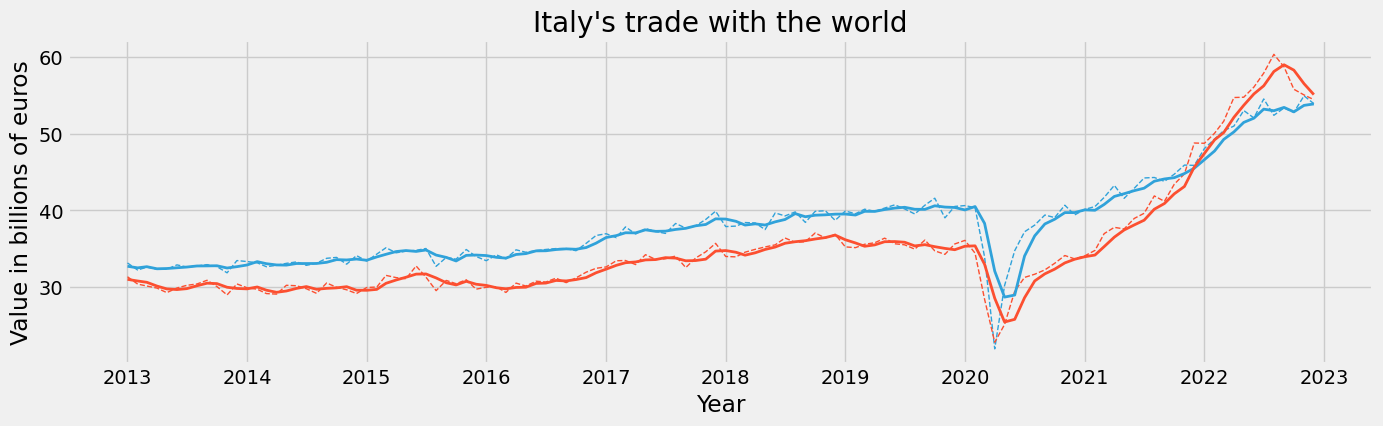

In [66]:
# Plot the data
after_2013 = trade_df["TIME_PERIOD"] >= "2013"
is_ESAV = trade_df["TIPO_DATO"] == "Exports"
is_ISAV = trade_df["TIPO_DATO"] == "Imports"

exports = trade_df[is_ESAV & after_2013].rename(columns={"OBS_VALUE": "Exports", "MA_3": "Exports - three months moving average"})
imports = trade_df[is_ISAV & after_2013].rename(columns={"OBS_VALUE": "Imports", "MA_3": "Imports - three months moving average"})

plt.plot(
    "TIME_PERIOD",
    "Exports",
    data=exports,
    marker="",
    linestyle="dashed",
    color = colors[0],
    linewidth=1
)
plt.plot(
    "TIME_PERIOD",
    "Imports",
    data=imports,
    marker="",
    linestyle="dashed",
    color = colors[1],
    linewidth=1
)
plt.plot(
    "TIME_PERIOD",
    "Exports - three months moving average",
    data=exports,
    color = colors[0],
    linewidth=2
)
plt.plot(
    "TIME_PERIOD",
    "Imports - three months moving average",
    data=imports,
    marker="",
    color = colors[1],
    linewidth=2
)

# add a title
plt.title("Italy's trade with the world")

# add a label to the x axis
plt.xlabel("Year")

# turn y scale from millions to billions (divide by a 1000), and add a label
plt.ylabel("Value in billions of euros")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000))))


And That's it! With a few lines of code we were able to neatly reproduce the graph!